In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import statsmodels.formula.api as smf
from helper_functions import linear_model_summary

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# This is not good practice, but is appropriate here for a beginners class.
# This allows us to not fuss with image sizes later in the presentation.
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# Linear Regression Introduction

## Loading and Inspecting the Data

For our example we will use a dataset dataset about various specimens of single species of insect collected across two continents.  The data was acquired from this question on CrossValidated, a statistics/data science question and answer site:

[Multiple regression, full and restricted model](http://stats.stackexchange.com/q/267034/74500)

We chose this dataset because it is small enough to be accessible, but has some interesting features for us to discover!

We will be interested in explaining how the insects wing span varies, as influenced by the other measurements in our dataset.

We'd like to load the `insects` data into python.  Our first step is to take a quick look at the raw data.

In [2]:
!head ./insects.csv

continent	latitude	wingsize	sex
1	40.5	941.111111111	0
1	42.0	924.444444444	0
1	43.6	924.204444444	0
1	45.7	915.217777778	0
1	45.9	905.471111111	0
1	47.4	896.004444444	0
1	50.0	913.0	0
1	51.8	916.44	0
1	53.8	933.417777778	0


It looks like there are four columns in our dataset:

```
continent, latitude, wingsize, and sex
```

Each data element is separated from the next by a tab character, so although it has the `.csv` extension, it is not comma separated.

In [3]:
insects = pd.read_csv('./insects.csv', sep='\t')
insects.head()

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0


We've got our four columns `continent, latitude, wingsize, and sex`.  

We can see some short descriptions of their qualities using `info`:

In [4]:
insects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
continent    42 non-null int64
latitude     42 non-null float64
wingsize     42 non-null float64
sex          42 non-null int64
dtypes: float64(2), int64(2)
memory usage: 1.4 KB


## Looking at the Data

We can get a first feel for how the quantities in our data are spread out using some histograms.

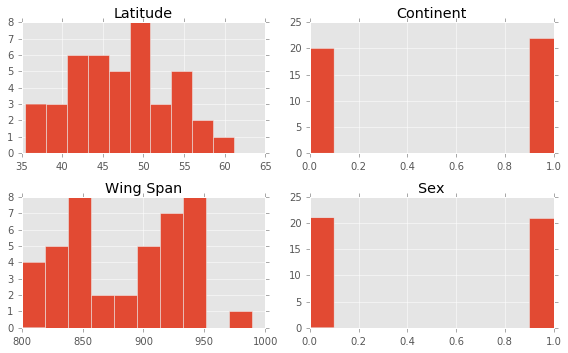

In [5]:
column_names = {
    "continent": "Continent",
    "latitude": "Latitude",
    "wingsize": "Wing Span",
    "sex": "Sex"
}

fig, axs = plt.subplots(2, 2)
for ax, (column, name) in zip(axs.flatten(), column_names.iteritems()):
    ax.hist(insects[column])
    ax.set_title(name)

fig.tight_layout()

**Discussion:** What have you learned form the data from these histograms?  How do they help you describe the data?

Some observations:

  - `continent` and `sex` take only two values.  There are two continents represented in the data, labeled zero and one, and there are two sexes (probably Male and Female), also labeled zero and one.
  
These zero/one columns are called **binary** or **indicator variables**, they measure a specific yes/no condition.

  - The values of `wingspan` cluster into two distinct groups.  This is very interesting, and worthy of investigation.

## Scatterplots

Histograms are useful, but limited, as they do not reveal anything about the *relationships between the columns in our data*.  To rectify this we turn to uncountably the most effective and flexible visualization, the **scatterplot**.

A good first step is to use `pandas.tools.plotting.scatter_matrix` to get a global view of our data.

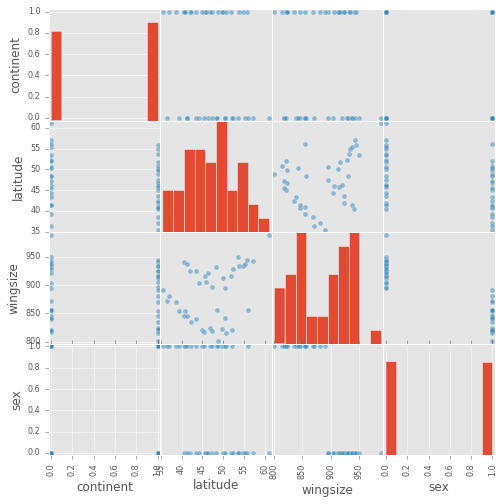

In [6]:
scatter_matrix(insects, figsize=(8, 8), s=100)
plt.show()

The `latitude` vs. `wingsize` scatterplot looks interesting, so let's take a close look at that.

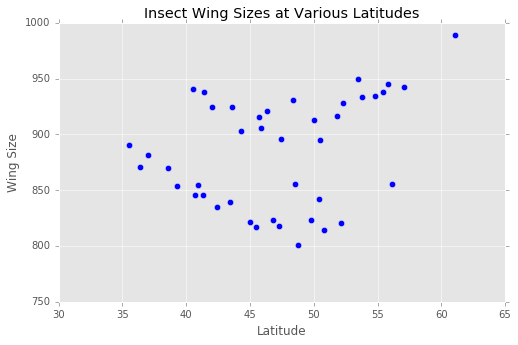

In [7]:
fig, ax = plt.subplots()

ax.scatter(insects.latitude, insects.wingsize, s=40)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Insect Wing Sizes at Various Latitudes")

**Discussion:** What patterns do you see in the scatterplot.  Can you form any hypothesis about the data?

Here are some thoughts:
    
  - The most prominent feature of this data is the two bands.  There seem to be two very well defined elongated clusters of data, with the average wingsize in one cluster much greater than in the other.
  - Within each cluster there is noticeable tendency for wingsize first decrease, and then increase as latitude varies.

## Linear Regression

This leads to a few questions we may wish to answer with the data.

  1. Are the two clusters associated with one of the other two variables in the dataset, `continent` or `sex?`
  2. Can we somehow summarize the way that `wingsize` varies with `latitude`?
  
Let's answer each of these questions.

### Are The Two Clusters Associated With Either Continent or Sex?

We can discover if the two clusters in the data are associated with either `continent` or `sex` through a well chosen visualization.  Let's make the same scatterplot from before, but color each point either red or blue, according to the value of `continent` or `sex`.

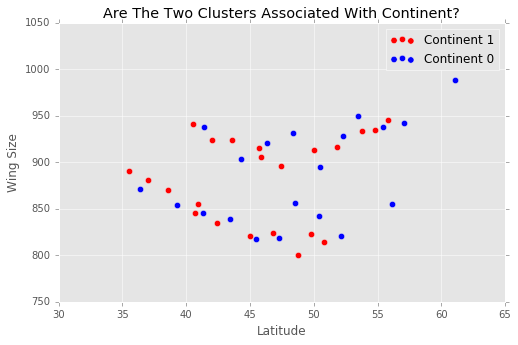

In [8]:
fig, ax = plt.subplots()

continent_boolean = insects.continent.astype(bool)
ax.scatter(insects.latitude[continent_boolean], 
           insects.wingsize[continent_boolean], 
           s=40, c="red", label="Continent 1")
ax.scatter(insects.latitude[~continent_boolean], 
           insects.wingsize[~continent_boolean],
           s=40, c="blue", label="Continent 0")
ax.set_xlabel("Latitude")
ax.set_ylabel("Wing Size")
ax.set_title("Are The Two Clusters Associated With Continent?")
ax.legend()

The values of continent seem scattered randomly across the two clusters, so it does **not** seem like continent is associated with the clusters.

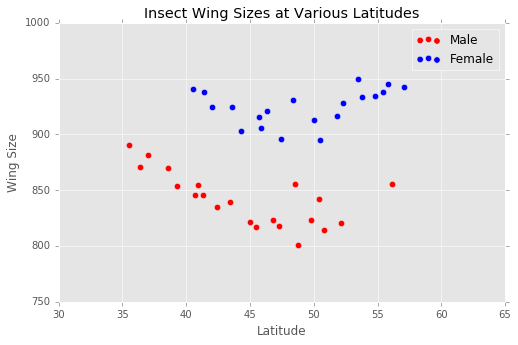

In [9]:
fig, ax = plt.subplots()

def make_insects_scatter_plot(ax):
    sex_boolean = insects.sex.astype(bool)
    ax.scatter(insects.latitude[sex_boolean], 
               insects.wingsize[sex_boolean],
               s=40, c="red", label="Male")
    ax.scatter(insects.latitude[~sex_boolean], 
               insects.wingsize[~sex_boolean],
               s=40, c="blue", label="Female")
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_scatter_plot(ax)

There we go!

This is pretty definitive, the cluster of the larger insects are all female, and the cluster of smaller insects are all male.  This seems like enough evidence to conclude that the sex of the insect causes the data to cluster into two groups.

**Note:** how little technology we needed to make this point convincingly.  It is *very important* to explore your data and use it to *ask and then answer* question like this.  Many data scientists reach immediately for their most powerful tools, which often leaves them with little to say when asked simple questions.

### Is An Increasing Latitude Associated With an Increasing Wing Size?

This question is a little more sophisticated, and we need some new technology to answer it.

The idea is to create an equation:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} $$

Then we can look at the number $b$, which tells us how we should expect `wingspan` to change as `latitude` changes.  If we find that $b > 0$, that's evidence that an increasing latitude is associated with an increasing wingspan.

I'll skip the technicalities, but the basic tool for creating equations like this is called **linear regression**.

In [10]:
linear_model = smf.ols(formula='wingsize ~ latitude', data=insects)
insects_model = linear_model.fit()
linear_model_summary(insects_model)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept                765.20           56.28
latitude                   2.54            1.18


The linear regression has attempted to estimate the equation we are after, and it has returned:

$$ \text{Wing Span} \approx 765.20 + 2.54 \times \text{Latitude} $$

So we can expect an on average increase of $2.54$ wingspan for every increase in one latitude.

The numbers estimated in linear regression are called **parameter estimates** or **coefficient estimates** and are usually denoted with the Greek letter $\beta$:

$$y \approx \beta_0 + \beta_1 x $$

The parameter estimate with no associated variable is usually called the **intercept**:

$$ \text{Wing Span} \approx \underbrace{765.20}_{\text{Intercept}} + \underbrace{2.54}_{\text{Parameter Estiamte}} \times \text{Latitude} $$


#### As the Equation of a Line

One way we can visualize this is to look at the regression as returning to us the equation for a line.  This line is the **best summary of the data** (under the assumption that a line is a reasonable way to summarize the data).

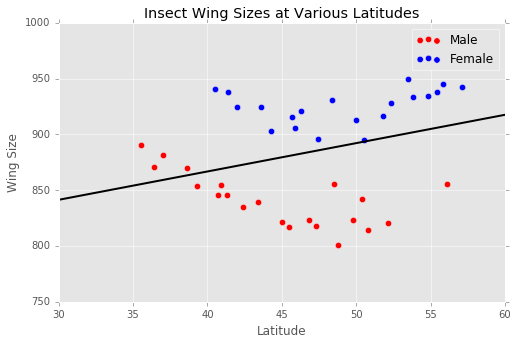

In [11]:
fig, ax = plt.subplots()

make_insects_scatter_plot(ax)

# Make a line graph of the predictions.
def make_insects_model_line(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model.params[0] + insects_model.params[1] * x,
           linewidth=2, c="black")
    ax.set_xlim(30, 60)

make_insects_model_line(ax)

**Discussion:** Does this model have any issues?  If so, what are they?

This plot elucidates two serious flaws in our model:

  - It has no knowledge of the sex of the insect, so the fit line attempts to bisect the two clusters of data.
  - It cannot account for the curvature in the data points.  The model attempts to fit a line to data that does not have a linear shape.

#### As a Method for Making Predictions

Another way to look at the regression result is as a way to make predictions.

If we *know* the latitude that we find an insect, we can *predict* the wing span as a function of the latitude:

$$ \text{PredictedWingSpan}(\text{Latitude}) = 765.20 + 2.54 \times \text{Latitude} $$

#### Inferential vs. Predictive Modeling

This is the first example we will encounter of **inferential vs. predictive statistics**:

- **Inferential Statistics** views the role of the model as a **summary of the data**.  We can then ask it questions like "is knowing the `continent` useful for producing an accurate summary of the data"?
- **Predictive Statistics** views the role of the model as a tool for **making predictions**.  We can ask the model questions like "What would I expect the value of `wingspan` to be for a value of `latitude` I have not yet observed"?

These are clearly related.  In the authors opinion, a model must be useful for making predictions to be meaningful for inference.

### How is the Line Determined?

Before we make the model more complicated, it would be good to know *how* our model is determining the line to fit to the data.

As we mentioned, we can think of the fitted line as a *prediction*.  If we were to collect a new insect at a certain latitude, the y-coordinate of the line would be our best estimate for the wing span of that insect.

A good strategy for drawing the line would seem to be:

> Try to draw the line that minimizes the dissimilarity between the predictions and the actual $y$ data.

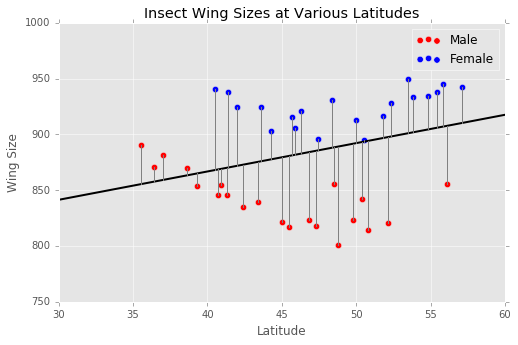

In [12]:
fig, ax = plt.subplots()

make_insects_scatter_plot(ax)
make_insects_model_line(ax)

# Draw a bunch of vertical lines to illustrate the difference between
# predictions and actuals.
for index, row in insects.iterrows():
    t = row['latitude']
    pred = insects_model.params[0] + insects_model.params[1] * t
    ax.plot((t, t), (row['wingsize'], pred), color='grey')

In the picture above we have highlighted the vertical distance between each data point and its predicted value.

A common numeric measure of the dissimilarity is the *sum of squared residuals*:

$$ SSR = \sum_{i=1}^N (y_i - \text{pred}_i)^2 $$

**The linear regression line is the line that minimizes that sum of squared residuals.**

#### Why the Sum of Squared Residuals?

The sum of squared residuals may seem like a strange measure of dissimilarity to use, more natural may be something like the sum of absolute residuals:

$$ SAR = \sum_{i=1}^N \left| y_i - \text{pred}_i \right| $$

There's really nothing stopping us from using SAR instead of SSR, and SAR is more appropriate for certain situations.  But we must be clear:

**The line created by minimizing SSR is DIFFERENT from the line formed by minimizing the SAR, and they have different properties**.


**Discussion:** In which ways should we expect the lines drawn by minimizin SSR and SAR to differ?  Think about how they would react as you move around datapoints.

In [13]:
median_model = smf.quantreg(formula='wingsize ~ latitude', data=insects)
insects_median_model = median_model.fit(q=0.5)

linear_model_summary(insects_median_model, name="SAR")
print
linear_model_summary(insects_model, name='SSR')

               SAR Model Summary               
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept                705.93           91.72
latitude                   4.14            1.93

               SSR Model Summary               
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept                765.20           56.28
latitude                   2.54            1.18


Plotting both lines makes the point even more obvious.

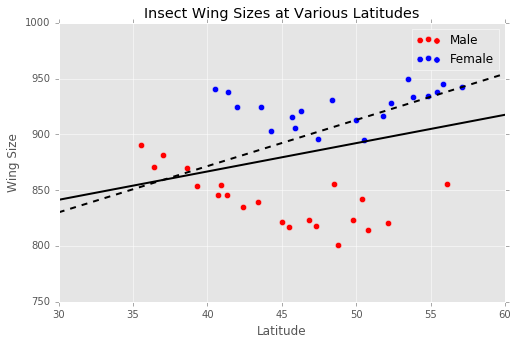

In [14]:
fig, ax = plt.subplots()

make_insects_scatter_plot(ax)
make_insects_model_line(ax)

def make_insects_median_model_line(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_median_model.params[0] + insects_median_model.params[1] * x,
           linewidth=2, c="black", linestyle="--")
    ax.set_xlim(30, 60)
    
make_insects_median_model_line(ax)

#### Mathematical Details

This leaves open the question of **how** we would minimize the sum of squared residuals

$$ SSR = \sum_{i=1}^N (y_i - \text{pred}_i)^2 $$

One of the reasons that linear models are so popular is that this is the **easiest possible function to minimize**.  In fact, with some calculus, you can show that minimizing the sum of squared residuals is the **same as** solving the following matrix equation:

$$ X^t X \beta = X^t y $$

Here

  - $X$ is the matrix of predictors.  Each column in one predictor, and each row is one observation.
  - $y$ is the vector of responses.
  - $\beta$ are the unknown parameters.
  
Notice that this is a system of linear equations, and there is one equation for each predictor.  As we know, solving linear equations is the **most basic possible problem in computational mathematics**.

### Accounting for the Sex of the Insect

It would much better to take account of the sex of the index and fit two lines, we make one line of prediction of the wing size given the latitude for males, and another for females.

The easiest way to do this is to modify our equation:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Sex} $$

There is now another term: if the insect is male we *add $c$* to the prediction, otherwise we add nothing.

Again, linear regression can find an equation of this shape describing the data:

In [15]:
linear_model = smf.ols(formula='wingsize ~ latitude + sex', data=insects)
insects_model_with_sex = linear_model.fit()
linear_model_summary(insects_model_with_sex)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept                948.25           31.66
latitude                  -0.41            0.63
sex                      -88.03            7.70


A couple of points are important:

- We now have an estimate for the number $c$ of $-98.86$.  This means, that on average, being male costs an insect about $-98.86$ in wingspan.
- The parameter estimates for the `Intercept` and for `latitude` **have changed**.  This is a very common situation.  When we fit a model with multiple variables, the model accounts for both how the variables are related to $y$, **and** how they are related to **each other**.

The predictions from this model now depend on whether an insect is male or female, meaning that we can draw one line for males, and one line for females.

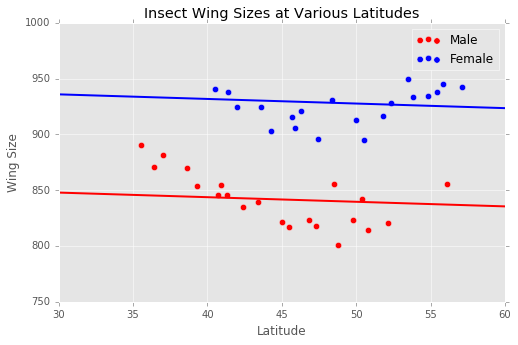

In [16]:
fig, ax = plt.subplots()

make_insects_scatter_plot(ax)

def make_insects_model_lines(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model_with_sex.params[0] 
                 + insects_model_with_sex.params[1] * x,
           linewidth=2, c="blue")
    ax.plot(x, insects_model_with_sex.params[0] 
                 + insects_model_with_sex.params[1] * x + insects_model_with_sex.params[2],
           linewidth=2, c="red")
    ax.set_xlim(30, 60)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_model_lines(ax)

The model is now fitting much better to the data, but the curvature of the scatterplots is still an issue.

### Accounting for the Curvature of the Data Points

We can account for the curvature of the data points by using a *polynomial regression*.  This means that we fit powers of latitude bigger than one:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} $$

In [17]:
linear_model = smf.ols(formula='wingsize ~ latitude + I(latitude**2) + sex', data=insects)
insects_model_quad = linear_model.fit()
linear_model_summary(insects_model_quad)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept               1946.89           91.87
latitude                 -43.21            3.89
I(latitude ** 2)           0.45            0.04
sex                      -89.46            3.81


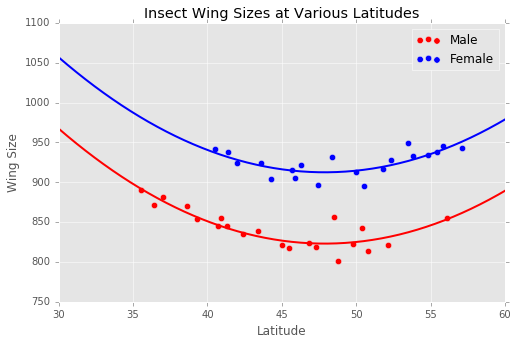

In [18]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
make_insects_scatter_plot(ax)

def make_insects_model_quadratic(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad.params[1] * x
                 + insects_model_quad.params[2] * x*x,
           linewidth=2, c="blue")
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad.params[1] * x
                 + insects_model_quad.params[2] * x*x
                 + insects_model_quad.params[3],
           linewidth=2, c="red")
    ax.set_xlim(30, 60)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_model_quadratic(ax)

Now we have a good fit to our data.

**Discussion:** Should we go further and add higher degree terms into the model?  Why or why not?  What would happen if do?

### Inference Using a Linear Model

Let's use our model to answer an inferential question: does continent has any effect on wing size?

To accomplish this, we modify our model from this:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} $$

to the slightly more complicated

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent} $$

Then the new number $e$ captures the effect of the insect being found on the continent labeled $1$.  **If $e$ is zero, or close to zero, then continent has no effect on wing span**.

Let's estimate the model:

In [19]:
linear_model = smf.ols(formula='wingsize ~ latitude + I(latitude**2) + sex + continent',
                       data=insects)
insects_model_quad_with_continent = linear_model.fit()
linear_model_summary(insects_model_quad_with_continent)

              Linear Model Summary             
Name         Parameter Estimate  Standard Error
-----------------------------------------------
Intercept               1945.39           91.51
latitude                 -42.96            3.88
I(latitude ** 2)           0.45            0.04
sex                      -89.90            3.81
continent                 -4.11            3.58


Now we have four different possible combinations of indicator variables

  - `sex == 0 and continent == 0`
  - `sex == 1 and continent == 0`
  - `sex == 0 and continent == 1`
  - `sex == 1 and continent == 1`
  
Which results in four curves being fit (though the **shape** of the quadratic trend is the same for each, as the parameters associated with latitude are **shared**).

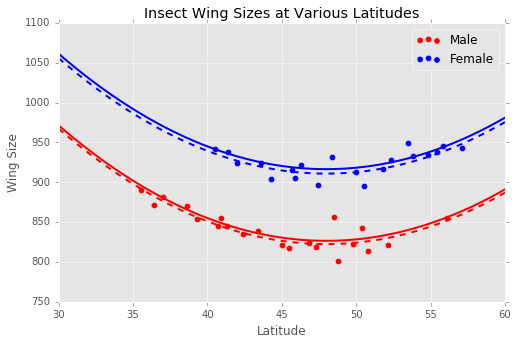

In [20]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
make_insects_scatter_plot(ax)

def make_insects_model_quadratic_and_continent(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x,
           linewidth=2, c="blue")
    ax.plot(x, insects_model_quad_with_continent.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x
                 + insects_model_quad_with_continent.params[4],
           linewidth=2, c="blue", linestyle="--")
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x
                 + insects_model_quad_with_continent.params[3],
           linewidth=2, c="red")
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x
                 + insects_model_quad_with_continent.params[3]
                 + insects_model_quad_with_continent.params[4],
           linewidth=2, c="red", linestyle="--")
    ax.set_xlim(30, 60)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_model_quadratic_and_continent(ax)

The effect of the `continent` variable is seen here as the difference between the solid and dashed lines.  It's evident from this plot that `continent` is not very useful in describing the `wingsize` of our insects.

#### Linear Regression p-values

One way to formalize this idea is using the p-values reported in the full summary of a linear regression model:

In [21]:
insects_model_quad_with_continent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     186.1
Date:                Sun, 07 May 2017   Prob (F-statistic):           5.83e-24
Time:                        15:31:44   Log-Likelihood:                -158.41
No. Observations:                  42   AIC:                             326.8
Df Residuals:                      37   BIC:                             335.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1945.3896     91.505     21.260      0.000    1759.983    2130.796
latitude           -42.9562      3.883    -11.062      0.000     -50.824     -35.088
I(latitude ** 2)     0.4477      0.041     10.953      0.000       0.365       0.530
sex                -89.9019      3.811    -23.593      0.000     -97.623     -82.181
continent           -4.1069      3.580     -1.147      0.259     -11.361       3.148
==============================================================================
Omnibus:                        2.477   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.455
Skew:                           0.257   Prob(JB):                        0.483
Kurtosis:                       3.753   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Recall that a **p-value** describes the amount of surprise that we feel when observing data, given that we are taking a skeptical stance on how that data is generated.

$$ P(\text{Observing A Statistic Equal or More Extreme than Actual} \mid H_0) $$

So to make sense of the p-values here, we need to describe the **null hypothesis** and the **statistic**.

The **null hypothesis** in this case is that each value of $y$ was generated by sampling from a relationship like:

$$ y \sim N(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + 0 \times \text{Continent}, \sigma) $$

Notice that in the null hypothesis, we are assuming **the effect of continent is zero, so we would be surprised to find it very non-zero**.

Given this null hypothesis, the **p-value** reported in linear regression is

$$ P(\text{Observe a Parameter Estimate for Continent More Extreme Than the Fit Model} \mid H_0) $$

Our p-value for continent was $0.26$, so it's quite likely that we would observe a parameter estimate equally or more extreme than we actually did, even if the true effect was zero.  This is consistent with what we saw in our picture.

#### A Final Word on Assumptions

There is a subtlety to our hypothesis test above.

The Null Hypothesis can be **false in more than one way**:

  - It could be, as we discussed already, that the true effect of `continent` is *not-zero*.  This is the situation we are trying to detect.
  - It could be that the value of $y$ was *not created by sampling from a normal distribution centered at the predicted value*.
  
For example, it could be that the value of $y$ was created by sampling from some other distribution:

$$ y \sim \text{Poisson}(a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} + e \times \text{Continent}) $$

In this case we **cannot deduce that $e \neq 0$, even if we reject the null hypothesis**.

For this reason, it is important to visually inspect the residuals of the fit model, and check that the assumption of normally distributed residuals seems a reasonable one.

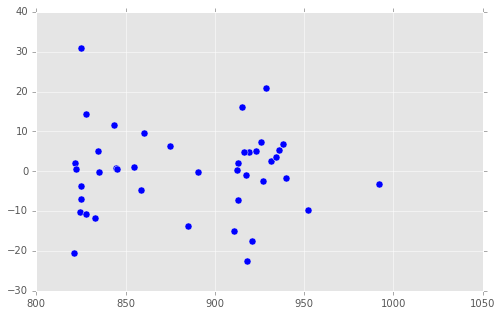

In [22]:
fig, ax = plt.subplots()

ax.scatter(insects_model_quad_with_continent.fittedvalues,
           insects_model_quad_with_continent.resid, s=50)

There are no obvious patterns in this plot, and the data does thin out as we move away from the x-axis.  This is consistent with what we would see if our data was generated as specified in the null hypothesis.